<a href="https://colab.research.google.com/github/lyj041214/ESAA/blob/main/HW_0428.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [개념 정리]

## 10. 분류 실습 - 캐글 신용카드 사기 검출

### 언더 샘플링과 오버 샘플링의 이해
지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해 적절한 학습 데이터를 확보하는 방안이 필요한데, 대표적으로 오버 샘플링과 언더 샘플링이 있다.

#### 언더 샘플링
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
- 줄여버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상레이블 데이터를 감소시켜 제대로된 학습을 수행할 수 없는 경우도 발생함.

#### 오버 샘플링
- 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 원본 데이터의 피처값을 아주 약간만 변경하여 증식하여 과적합 방지
- SMOTE 방법: 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식


### 데이터 일차 가공 및 모델 학습/예측/평가
- LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가 수행

### 데이터 분포도 변환 후 모델 학습/예측/평가
- 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트함.
- Amount 피처가 신용카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 중요한 속성일 것.

### 이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치를 찾아내고 이를 제거한 뒤 다시 모델을 평가하는 방법
- IQR 방법 이용 : 이상치, 최댓값, Q3,Q2,Q1, 최솟값, 이상치 찾기

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- SMOTE를 적용할 떄는 반드시 학습 데이터 세트만 오버 샘플링 해야함.
- fit_resample() 메서드를 이용해 증식한 뒤 증식 전 데이터와 비교

# [코드 필사]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
cust_df=pd.read_csv('train_santander.csv',encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied ratio is {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied ratio is 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_features,y_labels,test_size=0.2,random_state=0)
train_cnt=y_train.count()
test_cnt=y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [9]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리.
X_tr, X_val, y_tr, y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=0)

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf=XGBClassifier(n_estimators=500,random_state=156)
xgb_clf.set_params(eval_metric='auc',early_stopping_rounds=100)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83537	validation_1-auc:0.81654
[1]	validation_0-auc:0.84205	validation_1-auc:0.82807
[2]	validation_0-auc:0.84915	validation_1-auc:0.83188
[3]	validation_0-auc:0.85492	validation_1-auc:0.83182
[4]	validation_0-auc:0.85823	validation_1-auc:0.83286
[5]	validation_0-auc:0.86018	validation_1-auc:0.83497
[6]	validation_0-auc:0.86367	validation_1-auc:0.83863
[7]	validation_0-auc:0.86804	validation_1-auc:0.83867
[8]	validation_0-auc:0.87165	validation_1-auc:0.83744
[9]	validation_0-auc:0.87466	validation_1-auc:0.84027
[10]	validation_0-auc:0.87686	validation_1-auc:0.84064
[11]	validation_0-auc:0.87897	validation_1-auc:0.83964
[12]	validation_0-auc:0.88142	validation_1-auc:0.83941
[13]	validation_0-auc:0.88264	validation_1-auc:0.83903
[14]	validation_0-auc:0.88387	validation_1-auc:0.83915
[15]	validation_0-auc:0.88507	validation_1-auc:0.83965
[16]	validation_0-auc:0.88746	validation_1-auc:0.84010
[17]	validation_0-auc:0.88791	validation_1-auc:0.84053
[18]	validation_0-au

In [30]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space={'max_depth':hp.quniform('max_depth',5,15,1),
                  'min_child_weight':hp.quniform('min_child_weight',1,6,1),
                  'colsample_bytree':hp.uniform('colsample_bytree',0.5,0.95),
                  'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf=XGBClassifier(n_estimators=100,max_depth=int(search_space['max_depth']),
                        min_child_weight=int(search_space['min_child_weight']),
                        colsample_bytree=search_space['colsample_bytree'],
                        learning_rate=search_space['learning_rate'])

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index,val_index in kf.split(X_train):
    # kf.split(X_train)을 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

    # early_stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.set_params(eval_metric='auc',early_stopping_rounds=100)
    xgb_clf.fit(X_tr,y_tr,eval_set=[(X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val,xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [32]:
from hyperopt import fmin, tpe, Trials

trials=Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50,  # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))
print('best:',best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[2]	validation_0-auc:0.81175
[3]	validation_0-auc:0.81953
[4]	validation_0-auc:0.82328
[5]	validation_0-auc:0.82448
[6]	validation_0-auc:0.82505
[7]	validation_0-auc:0.82275
[8]	validation_0-auc:0.82439
[9]	validation_0-auc:0.82504
[10]	validation_0-auc:0.82578
[11]	validation_0-auc:0.82571
[12]	validation_0-auc:0.82632
[13]	validation_0-auc:0.82706
[14]	validation_0-auc:0.82691
[15]	validation_0-auc:0.82727
[16]	validation_0-auc:0.82740
[17]	validation_0-auc:0.82867
[18]	validation_0-auc:0.82862
[19]	validation_0-auc:0.82906
[20]	validation_0-auc:0.82913
[21]	validation_0-auc:0.82820
[22]	validation_0-auc:0.82866
[23]	validation_0-auc:0.82915
[24]	validation_0-auc:0.82935
[25]	validation_0-auc:0.82918
[26]	validation_0-auc:0.82927
[27]	validation_0-auc:0.82902
[28]	validation_0-auc:0.82912
[29]	validation_0-auc:0.82935
[30]	validation_0-auc:0.82932
[31]	validation_0-auc:0.82940
[32]	validation_0-auc:0.82963
[33]	validation_0-auc:0.82943
[34]	validat

In [33]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf=XGBClassifier(n_estimators=500,learning_rate=round(best['learning_rate'],5),
                      max_depth=int(best['max_depth']),
                      min_child_weight=int(best['min_child_weight']),
                      colsample_bytree=round(best['colsample_bytree'],5)
                      )

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
xgb_clf.set_params(eval_metric='auc',early_stopping_rounds=100)
xgb_clf.fit(X_train, y_train,eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83227	validation_1-auc:0.83597
[1]	validation_0-auc:0.84364	validation_1-auc:0.84587
[2]	validation_0-auc:0.84063	validation_1-auc:0.83911
[3]	validation_0-auc:0.84584	validation_1-auc:0.84461
[4]	validation_0-auc:0.84818	validation_1-auc:0.84713
[5]	validation_0-auc:0.84960	validation_1-auc:0.84959
[6]	validation_0-auc:0.85068	validation_1-auc:0.85127
[7]	validation_0-auc:0.85070	validation_1-auc:0.84799
[8]	validation_0-auc:0.85154	validation_1-auc:0.84816
[9]	validation_0-auc:0.85309	validation_1-auc:0.85007
[10]	validation_0-auc:0.85385	validation_1-auc:0.85146
[11]	validation_0-auc:0.85479	validation_1-auc:0.85308
[12]	validation_0-auc:0.85515	validation_1-auc:0.85434
[13]	validation_0-auc:0.85551	validation_1-auc:0.85425
[14]	validation_0-auc:0.85589	validation_1-auc:0.85468
[15]	validation_0-auc:0.85670	validation_1-auc:0.85669
[16]	validation_0-auc:0.85753	validation_1-auc:0.85629
[17]	validation_0-auc:0.85840	validation_1-auc:0.85641
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

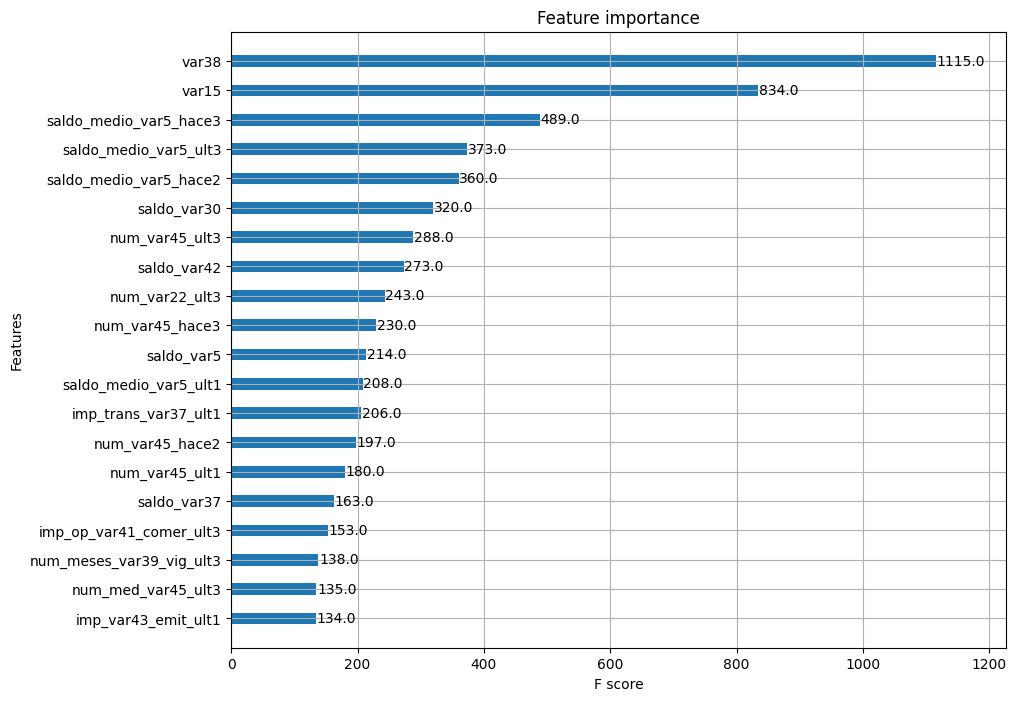

In [35]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

In [36]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=500)

eval_set=[(X_tr,y_tr),(X_val,y_val)]
lgbm_clf.set_params(early_stopping_rounds=100,eval_metric='auc')
lgbm_clf.fit(X_tr,y_tr,eval_set=eval_set)

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 2121, number of negative: 52613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14060
[LightGBM] [Info] Number of data points in the train set: 54734, number of used features: 251
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038751 -> initscore=-3.211076
[LightGBM] [Info] Start training from score -3.211076
Training un

In [46]:
lgbm_search_space={'num_leaves':hp.quniform('num_leaves',32,64,1),
                   'max_depth':hp.quniform('max_depth',100,160,1),
                   'min_child_samples':hp.quniform('min_child_samples',60,100,1),
                   'subsample':hp.quniform('subsample',0.7,1,0.01),
                   'learning_rate':hp.quniform('learning_rate',0.01,0.2,0.01)}

In [47]:
def objective_func(search_space):
  lgbm_clf=LGBMClassifier(n_estimators=100,num_leaves=int(search_space['num_leaves']),
                          max_depth=int(search_space['max_depth']),
                          min_child_samples=int(search_space['min_child_samples']),
                          subsample=search_space['subsample'],
                          learning_rate=search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index,val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    lgbm_clf.set_params(early_stopping_rounds=100)
    lgbm_clf.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val,lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [48]:
from hyperopt import fmin,tpe, Trials

trials=Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,space=lgbm_search_space,algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))

print('best:',best)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.123648	valid_1's binar

In [52]:
lgbm_clf=LGBMClassifier(n_estimators=500,num_leaves=int(best['num_leaves']),
                        max_depth=int(best['max_depth']),
                        min_child_samples=int(best['min_child_samples']),
                        subsample=round(best['subsample'],5),
                        learning_rate=round(best['learning_rate'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.set_params(early_stopping_rounds=100,eval_metric='auc')
lgbm_clf.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)])

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 2121, number of negative: 52613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.455250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13845
[LightGBM] [Info] Number of data points in the train set: 54734, number of used features: 219
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038751 -> initscore=-3.211076
[LightGBM] [Info] Start training from score -3.211076
Training un

## 10. 분류 실습 - 캐글 신용카드 사기 검출

In [54]:
%pip install -c conda-forge imbalanced-learn

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [56]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

In [57]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy=get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

In [58]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [59]:
# 이전 코드
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)

    roc_auc=roc_auc_score(y_test,pred_proba)
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [60]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149, F1:0.7222, AUC:0.9575


In [61]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test,pred,pred_proba)

In [62]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

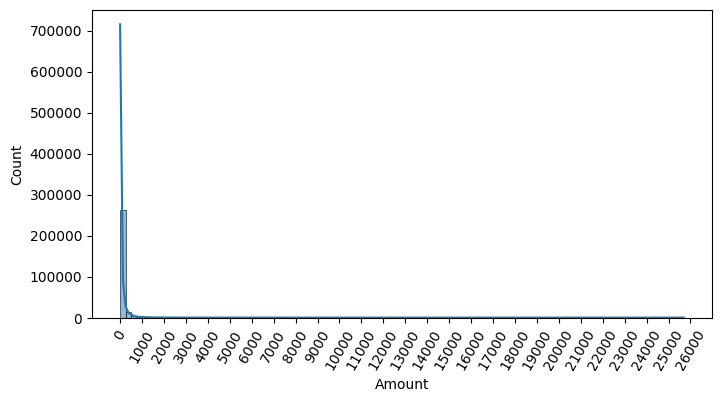

In [63]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'],bins=100,kde=True)
plt.show()

In [64]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [65]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1:0.7294, AUC:0.9706
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [66]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [67]:
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1:0.7120, AUC:0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

<Axes: >

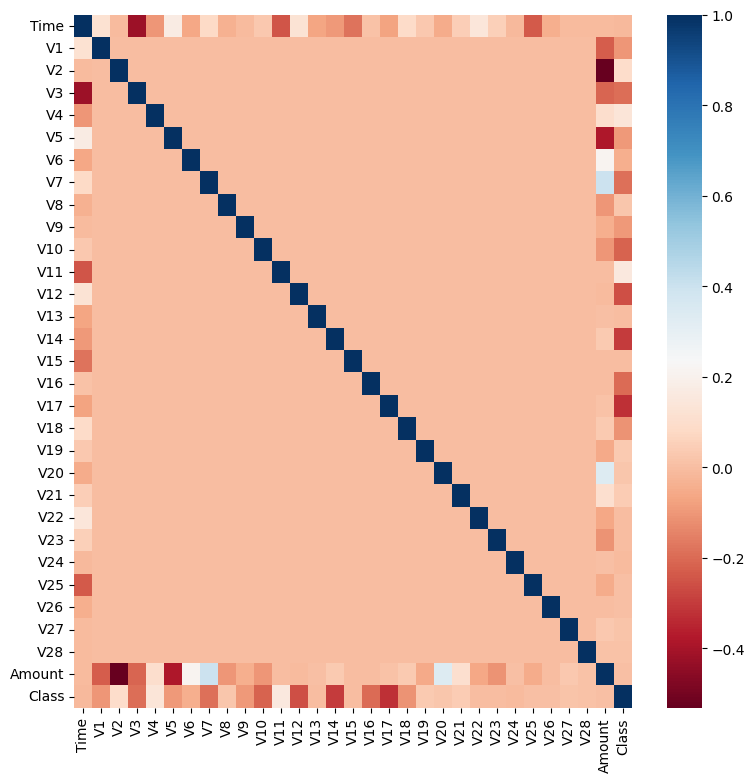

In [68]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [71]:
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)

  #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr=quantile_75-quantile_25
  iqr_weight=iqr * weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index=fraud[(fraud<lowest_val)| (fraud>highest_val)].index
  return outlier_index

In [73]:
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [74]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1:0.7568, AUC:0.9725
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [75]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',X_train.shape,y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:',X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [78]:
lr_clf=LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1:0.1022, AUC:0.9736


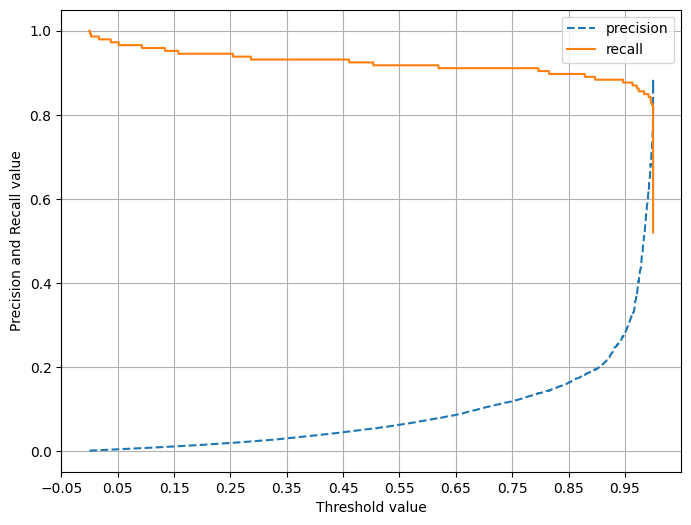

In [90]:
# 이전 코드
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test,pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X 축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

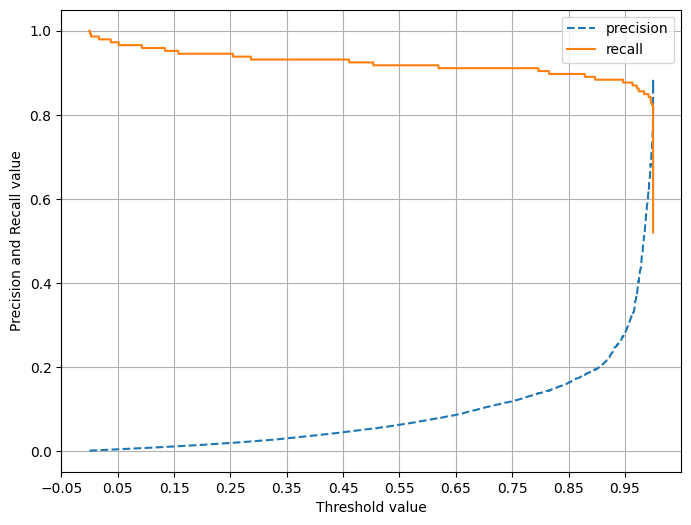

In [91]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [92]:
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split